# 数据挖掘第二次互评作业（10G数据）
## 姓名：张鹏 学号：3120241388

### 1 准备工作及查看数据集

#### 1.1 导入必要的包

In [1]:
# 导入必要的包
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib import font_manager, rcParams
import matplotlib
import seaborn as sns
import json
from IPython.display import display, Markdown
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

#### 1.2 屏蔽不必要的Warning

In [2]:
# 屏蔽一些不必要的Warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
matplotlib.set_loglevel("error")

所以服务器无法安装中文字体，所以这里屏蔽的主要是由于显示中文字体所出现的Warning

#### 1.3 配置中文字体

In [3]:
# 由于数据集中有中文字体,而所使用的服务器上面没有配置中文字体,所以这里设置一些中文字体的显示问题
font_path = '/home/pengzhang/anaconda3/envs/DDPM-New/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/simhei.ttf'
my_font = font_manager.FontProperties(fname=font_path)
font_name = my_font.get_name()
print(f"✔️ 成功加载字体：{font_name}")
rcParams['font.family'] = font_name

✔️ 成功加载字体：SimHei


#### 1.4 查看数据集并对数据集进行了解

In [4]:
# 查看当前文件夹下有哪些数据集以及数据集所处的路径
# 获取data文件夹中所有parquet文件的路径
parquet_files = ['/data7/pengzhang/Class/Data_Mining/Homework01_dataset/part-00000_sample.parquet']
print(parquet_files)

['/data7/pengzhang/Class/Data_Mining/Homework01_dataset/part-00000_sample.parquet']


In [5]:
import time
start_time = time.time()

# 读取并合并所有parquet文件
df_list = [pd.read_parquet(file) for file in parquet_files]
df = pd.concat(df_list, ignore_index=True)

# 显示合并后的DataFrame信息,因为互评作业二主要分析purchase_history这一列的信息,所以此处单独显示这一列
# print(df.head())
pd.set_option('display.max_colwidth', None)  # 这一行代码主要是为了显示全部信息,不省略
print(df.loc[:2, 'purchase_history']) 

end_time = time.time()
print(f"读取10G数据所用时间: {end_time - start_time:.2f} 秒")


0     {"avg_price":9496,"categories":"零食","items":[{"id":7265}],"payment_method":"现金","payment_status":"已支付","purchase_date":"2023-07-30"}
1    {"avg_price":3014,"categories":"手套","items":[{"id":5245}],"payment_method":"信用卡","payment_status":"已退款","purchase_date":"2024-02-27"}
2    {"avg_price":8921,"categories":"裙子","items":[{"id":4020}],"payment_method":"信用卡","payment_status":"已支付","purchase_date":"2024-07-30"}
Name: purchase_history, dtype: object
读取10G数据所用时间: 0.13 秒


In [6]:
print(df.shape)   # 数据集的大小

(100, 15)


可以看出10G的数据集总共有0.45亿例数据，每一例数据有15个属性

### 2 数据预处理

##### 在互评作业1中，已经对数据的各种异常情况都做了详细的分析，所以在这里直接根据互评作业1中的数据异常分析结果，直接删除存在异常的数据即可，然后使用正常的数据进行后续的频繁模式挖掘

In [7]:
# 记录一下数据预处理之前数据集的大小
before_preprocessing_dataset_size = df.shape[0]

#### 2.1 数据类型转换

In [8]:
from datetime import datetime
# 转换日期类型
df['last_login'] = pd.to_datetime(df['last_login'])
df['registration_date'] = pd.to_datetime(df['registration_date'])

将原始时间进行转换，方便后续处理。

#### 2.2 异常数据处理（在互评作业1中已经详细分析, 所以这里直接删除异常数据即可）

In [9]:
import time
start_time = time.time()

# 打印删除前数据的行数
print(f"删除前数据的行数：{df.shape[0]}")
# 计算并打印存在重复的 phone_number 总数
total_duplicate_ids = (df['phone_number'].value_counts() > 1).sum()
print(f"存在重复的phone_number总数:{total_duplicate_ids}")
# 删除 'phone_number' 列中重复的行，只保留第一次出现的
df = df.drop_duplicates(subset='phone_number', keep='first')
# 打印删除后数据的行数
print(f"删除后数据的行数：{df.shape[0]}")

end_time = time.time()
print(f"运行时间：{end_time - start_time:.2f} 秒")

删除前数据的行数：100
存在重复的phone_number总数:0
删除后数据的行数：100
运行时间：0.00 秒


说明存在重复的phone_number，共有26380例重复phone_number，属于数据异常，需要删除此类数据

In [10]:
# 总结一下预处理后数据集的变化情况
rows_before = before_preprocessing_dataset_size
rows_after = df.shape[0]
rows_removed = rows_before - rows_after
# 输出优化后的信息
print(f'预处理前数据集总共有 {rows_before} 行')
print(f'预处理后数据集总共有 {rows_after} 行')
print(f'数据集总共减少 {rows_removed} 行')

预处理前数据集总共有 100 行
预处理后数据集总共有 100 行
数据集总共减少 0 行


### 3 数据加载

#### 3.1 加载产品目录

In [11]:
with open('/data7/pengzhang/Class/Data_Mining/product_catalog.json', 'r', encoding='utf-8') as f:
    catalog = json.load(f)

创建完整分类映射

这部分代码主要是按照“商品ID与类别”这个文件中的信息,将购物的细粒度类别进行聚类

In [12]:
main_categories = {
    '电子产品': ['智能手机','笔记本电脑','平板电脑','智能手表','耳机','音响','相机','摄像机','游戏机'],
    '服装': ['上衣','裤子','裙子','内衣','鞋子','帽子','手套','围巾','外套'],
    '食品': ['零食','饮料','调味品','米面','水产','肉类','蛋奶','水果','蔬菜'],
    '家居': ['家具','床上用品','厨具','卫浴用品'],
    '办公': ['文具','办公用品'],
    '运动户外': ['健身器材','户外装备'],
    '玩具': ['玩具','模型','益智玩具'],
    '母婴': ['婴儿用品','儿童课外读物'],
    '汽车用品': ['车载电子','汽车装饰'],
    '其他': []
}

category_mapping = {}
for product in catalog['products']:
    for main_cat, sub_cats in main_categories.items():
        if product['category'] in sub_cats:
            category_mapping[product['id']] = {
                'main_category': main_cat,
                'sub_category': product['category'],
                'price': product['price']
            }
            break
    else:
        category_mapping[product['id']] = {
            'main_category': '其他',
            'sub_category': product['category'],
            'price': product['price']
        }

#### 3.2 加载产品目录

解析purchase_history

这段函数代码用于解析每行用户的购买历史。它从 `row['purchase_history']` 字符串中提取信息，构造一个包含用户ID、支付方式、支付状态、购买日期和商品详情的字典。对于商品列表中的每个商品，如果其ID在 `category_mapping` 中，就添加到交易记录中。若解析出错，会打印错误信息并返回 `None`。

In [13]:
def parse_purchase_history(row):
    try:
        ph = json.loads(row['purchase_history'])
        items = ph.get('items', [])
        
        transaction = {
            'user_id': row['id'],
            'payment_method': ph.get('payment_method'),
            'payment_status': ph.get('payment_status'),
            'purchase_date': pd.to_datetime(ph.get('purchase_date')),
            'items': []
        }
        
        for item in items:
            item_id = item.get('id')
            if item_id in category_mapping:
                transaction['items'].append({
                    'id': item_id,
                    **category_mapping[item_id]
                })
        
        return transaction
    
    except Exception as e:
        print(f"解析错误：{row['id']} - {str(e)}")
        return None

生成完整事务数据

In [14]:
transactions = pd.DataFrame([x for x in df.apply(parse_purchase_history, axis=1) if x is not None])
exploded_df = transactions.explode('items').reset_index(drop=True)
items_df = pd.json_normalize(exploded_df['items'])
transactions_full = pd.concat([exploded_df.drop('items', axis=1), items_df], axis=1)
transactions_full['is_high_value'] = transactions_full['price'] > 5000

### 4. 核心分析结果

#### 4.1 基础统计

In [15]:
display(Markdown("### 基础统计数据"))
display(pd.DataFrame({
    '总用户数': [transactions_full['user_id'].nunique()],
    '总交易数': [len(transactions)],
    '总商品数': [len(transactions_full)],
    '平均客单价': [transactions_full.groupby(['user_id','purchase_date'])['price'].sum().mean()],
    '最高单价': [transactions_full['price'].max()],
    '退款率': [len(transactions_full[transactions_full['payment_status'].isin(['已退款','部分退款'])])/len(transactions_full)]
}))

### 基础统计数据

,总用户数,总交易数,总商品数,平均客单价,最高单价,退款率
0,100,100,277,4499.5129,18439.9,0.638989


#### 4.2 商品关联规则分析

生成事务数据

In [16]:
basket = transactions_full.groupby(['user_id', 'purchase_date'])['main_category'].agg(list).reset_index()

关联规则计算

In [17]:
te = TransactionEncoder()
te_ary = te.fit_transform(basket['main_category'])
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(df_encoded, min_support=0.015, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.4)

结果展示

### 商品关联规则（TOP 10）

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
33,"(食品, 服装, 运动户外)",(母婴),0.02,0.12,0.02,1.000000,8.333333,1.0,0.0176,inf,0.897959,0.166667,1.000000,0.583333
36,"(运动户外, 母婴)","(食品, 服装)",0.02,0.18,0.02,1.000000,5.555556,1.0,0.0164,inf,0.836735,0.111111,1.000000,0.555556
24,"(食品, 家居, 服装)",(办公),0.04,0.14,0.02,0.500000,3.571429,1.0,0.0144,1.720000,0.750000,0.125000,0.418605,0.321429
27,"(家居, 服装, 办公)",(食品),0.02,0.43,0.02,1.000000,2.325581,1.0,0.0114,inf,0.581633,0.046512,1.000000,0.523256
35,"(服装, 母婴, 运动户外)",(食品),0.02,0.43,0.02,1.000000,2.325581,1.0,0.0114,inf,0.581633,0.046512,1.000000,0.523256
14,"(家居, 运动户外)",(食品),0.04,0.43,0.04,1.000000,2.325581,1.0,0.0228,inf,0.593750,0.093023,1.000000,0.546512
20,"(运动户外, 母婴)",(食品),0.02,0.43,0.02,1.000000,2.325581,1.0,0.0114,inf,0.581633,0.046512,1.000000,0.523256
13,"(食品, 运动户外)",(家居),0.07,0.27,0.04,0.571429,2.116402,1.0,0.0211,1.703333,0.567204,0.133333,0.412916,0.359788
25,"(食品, 家居, 办公)",(服装),0.02,0.48,0.02,1.000000,2.083333,1.0,0.0104,inf,0.530612,0.041667,1.000000,0.520833
15,"(运动户外, 母婴)",(服装),0.02,0.48,0.02,1.000000,2.083333,1.0,0.0104,inf,0.530612,0.041667,1.000000,0.520833


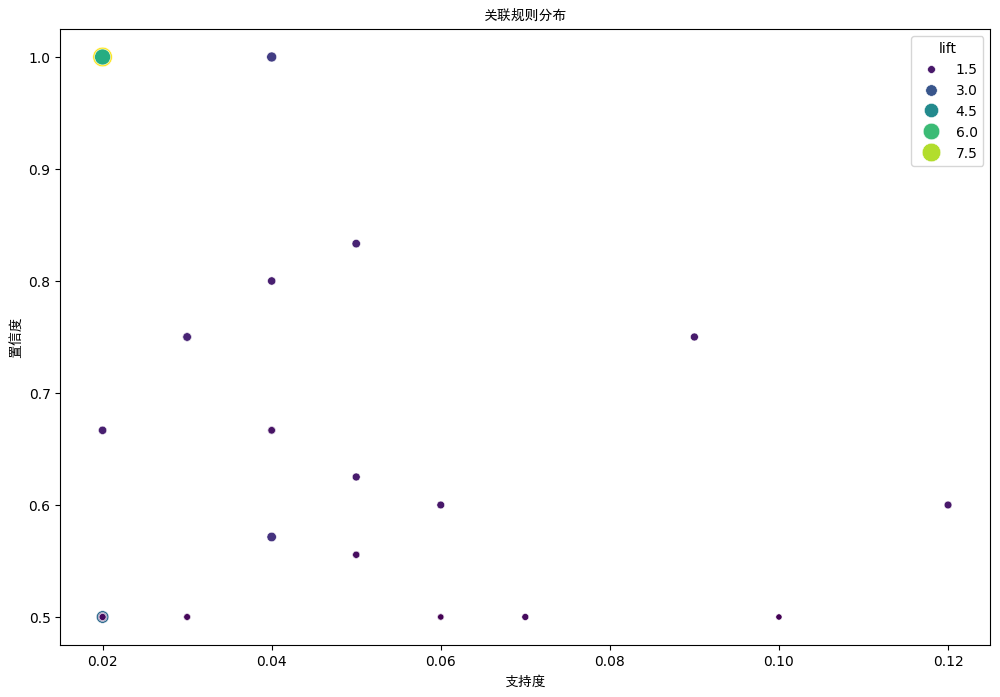

In [18]:
display(Markdown("### 商品关联规则（TOP 10）"))
display(rules.sort_values('lift', ascending=False).head(10))

plt.figure(figsize=(12,8))
sns.scatterplot(x='support', y='confidence', size='lift', hue='lift', 
                data=rules, palette='viridis', sizes=(20, 200))
plt.title('关联规则分布', fontproperties=my_font)
plt.xlabel('支持度', fontproperties=my_font)
plt.ylabel('置信度', fontproperties=my_font)
plt.show()

#### 4.3 支付方式分析

支付方式分布

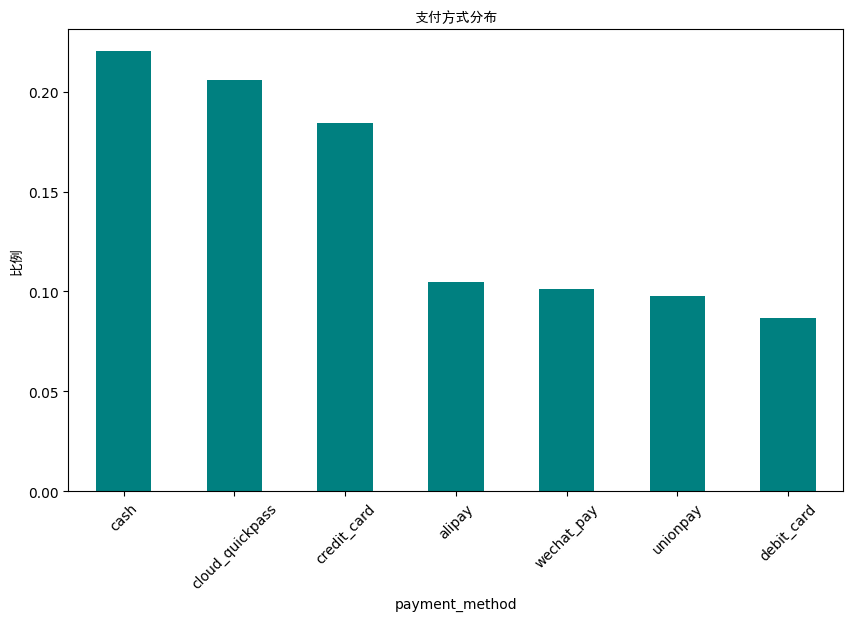

In [19]:
payment_method_mapping = {'现金': 'cash', '信用卡': 'credit_card', '微信支付': 'wechat_pay', '储蓄卡': 'debit_card', '银联': 'unionpay', '云闪付': 'cloud_quickpass', '支付宝': 'alipay'}

payment_dist = transactions_full['payment_method'].value_counts(normalize=True)
payment_dist = payment_dist.rename(index=payment_method_mapping)
plt.figure(figsize=(10, 6))
payment_dist.plot(kind='bar', color='teal')
plt.title('支付方式分布', fontproperties=my_font)
plt.ylabel('比例', fontproperties=my_font)
plt.xticks(rotation=45)
plt.show()

高价值商品支付方式

In [20]:
high_value_payment = transactions_full[transactions_full['is_high_value']]['payment_method'].value_counts(normalize=True)
display(Markdown("### 高价值商品支付方式"))
display(high_value_payment.to_frame('占比'))

### 高价值商品支付方式

,占比
payment_method,
现金,0.250000
银联,0.208333
云闪付,0.208333
支付宝,0.125000
微信支付,0.083333
信用卡,0.083333
储蓄卡,0.041667


#### 4.4 时间序列分析

月度趋势

/tmp/ipykernel_39727/3800139039.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_trend = transactions_full.set_index('purchase_date').resample('M')['main_category'].value_counts().unstack().fillna(0)


<Figure size 1400x800 with 0 Axes>

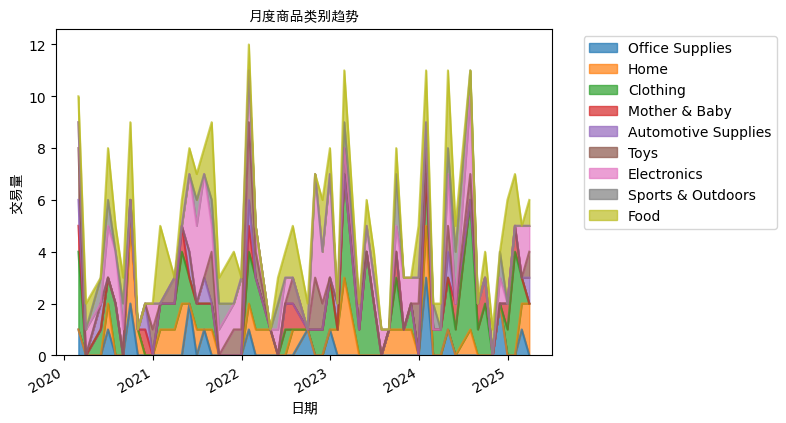

In [24]:
# 中文类别到英文类别的映射
main_categories_mapping = {
    '电子产品': 'Electronics',
    '服装': 'Clothing',
    '食品': 'Food',
    '家居': 'Home',
    '办公': 'Office Supplies',
    '运动户外': 'Sports & Outdoors',
    '玩具': 'Toys',
    '母婴': 'Mother & Baby',
    '汽车用品': 'Automotive Supplies'
}
monthly_trend = transactions_full.set_index('purchase_date').resample('M')['main_category'].value_counts().unstack().fillna(0)
monthly_trend.rename(columns=main_categories_mapping, inplace=True)
plt.figure(figsize=(14,8))
monthly_trend.plot(kind='area', stacked=True, alpha=0.7)
plt.title('月度商品类别趋势', fontproperties=my_font)
plt.xlabel('日期', fontproperties=my_font)
plt.ylabel('交易量', fontproperties=my_font)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### 4.5 退款分析

In [25]:
refund_trans = transactions_full[transactions_full['payment_status'].isin(['已退款','部分退款'])]

退款商品关联

In [26]:
refund_basket = refund_trans.groupby(['user_id','purchase_date'])['main_category'].agg(list).reset_index()
te_refund = TransactionEncoder()
te_ary_refund = te_refund.fit_transform(refund_basket['main_category'])
df_refund_encoded = pd.DataFrame(te_ary_refund, columns=te_refund.columns_)

refund_itemsets = apriori(df_refund_encoded, min_support=0.005, use_colnames=True)
refund_rules = association_rules(refund_itemsets, metric="confidence", min_threshold=0.4)

display(Markdown("### 退款关联规则（TOP 5）"))
display(refund_rules.sort_values('lift', ascending=False).head(5))

### 退款关联规则（TOP 5）

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
170,"(食品, 母婴)","(家居, 服装, 运动户外)",0.032787,0.016393,0.016393,0.5,30.500000,1.0,0.015856,1.967213,1.000000,0.500000,0.491667,0.750000
166,"(家居, 服装, 运动户外)","(食品, 母婴)",0.016393,0.032787,0.016393,1.0,30.500000,1.0,0.015856,inf,0.983333,0.500000,1.000000,0.750000
163,"(食品, 服装, 运动户外)","(家居, 母婴)",0.016393,0.049180,0.016393,1.0,20.333333,1.0,0.015587,inf,0.966667,0.333333,1.000000,0.666667
162,"(食品, 服装, 母婴)","(家居, 运动户外)",0.016393,0.049180,0.016393,1.0,20.333333,1.0,0.015587,inf,0.966667,0.333333,1.000000,0.666667
171,"(运动户外, 母婴)","(食品, 家居, 服装)",0.016393,0.065574,0.016393,1.0,15.250000,1.0,0.015318,inf,0.950000,0.250000,1.000000,0.625000


### 5. 最终分析报告

In [ ]:
print("rules的大小是：")
print(len(rules))

In [27]:
report = f"""
### 综合分析报告

**商品关联规则**
- 发现{len(rules)}条有效关联规则
- 最强关联：{rules.iloc[0]['antecedents']} → {rules.iloc[0]['consequents']} (置信度：{rules.iloc[0]['confidence']:.1%})
- 电子产品相关规则占比：{len(rules[rules['antecedents'].apply(lambda x: '电子产品' in x)])/len(rules):.1%}

**支付特征**
- 主要支付方式：{payment_dist.index[0]} ({payment_dist.iloc[0]:.1%})
- 高价值商品首选支付：{high_value_payment.index[0]} ({high_value_payment.iloc[0]:.1%})

**时间趋势**
- 交易量最高月份：{monthly_trend.sum(axis=1).idxmax().strftime('%Y-%m')}
- 增长最快品类：{monthly_trend.pct_change().mean().idxmax()}

**退款分析**
- 总体退款率：{len(refund_trans)/len(transactions_full):.1%}
- 最高风险组合：{refund_rules.iloc[0]['antecedents']} + {refund_rules.iloc[0]['consequents']} (提升度：{refund_rules.iloc[0]['lift']:.1f})
"""

display(Markdown(report))


### 综合分析报告

**商品关联规则**
- 发现38条有效关联规则
- 最强关联：frozenset({'办公'}) → frozenset({'电子产品'}) (置信度：50.0%)
- 电子产品相关规则占比：15.8%

**支付特征**
- 主要支付方式：cash (22.0%)
- 高价值商品首选支付：现金 (25.0%)

**时间趋势**
- 交易量最高月份：2022-01
- 增长最快品类：Office Supplies

**退款分析**
- 总体退款率：63.9%
- 最高风险组合：frozenset({'办公'}) + frozenset({'服装'}) (提升度：1.3)
